In [1]:
#imports 

import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v2.enable_v2_behavior()
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

In [2]:
#defining the function that will be called to produce a chirp signal
# it takes [x-points, chirp rate, initial frequency]
def chirp(x, c, f):
    ft = (x*c) + f
    c_sig = np.sin(2*np.pi*ft*x)
    return c_sig

In [87]:
#Declare the operating conditions for source and target
SNR_s = 15;
SNR_t = 12;
signal_amp = 1;
Ps = (signal_amp**2)/2
Pn_s = (Ps*10)**(-SNR_s/10)
Pn_t = (Ps*10)**(-SNR_t/10)
chirp_rate = 8;
num_points = 128; # for source

#instantiate the observation points of the source
x_source = (np.arange(0,1,1/num_points)).astype(np.float64)
x_source = x_source.reshape(len(x_source),1)

#target observation points
x_target_train = np.arange(0,0.25,0.25/16).astype(np.float64)
x_target_train = x_target_train.reshape(len(x_target_train), 1)


#y values for training the source and target models
y_source = chirp(x_source, chirp_rate, 2) + (np.random.normal(0, np.sqrt(Pn_s), len(x_source))).reshape(len(x_source),1)
y_source = y_source.reshape(len(y_source))

y_target_train = chirp(x_target_train, chirp_rate, 2) + (np.random.normal(0,np.sqrt(Pn_t),len(x_target_train))).reshape(len(x_target_train),1)
y_target_train = y_target_train.reshape(len(y_target_train))

y_source_true = (chirp(x_source, chirp_rate, 2)).reshape(num_points,)

index_points = (np.arange(0,1,1/400)).astype(np.float64)
index_points = index_points.reshape(len(index_points),1)

y_index = (chirp(index_points, chirp_rate, 2)).reshape(400,)

In [88]:
#setting some values for kernel hyperparameter optimization that will be used later
num_iters = 200
optimizer = tf.optimizers.Adam(learning_rate=0.01)
num_samples = 40;

Source and target observations
--------------

Text(0, 0.5, 'Amplitude')

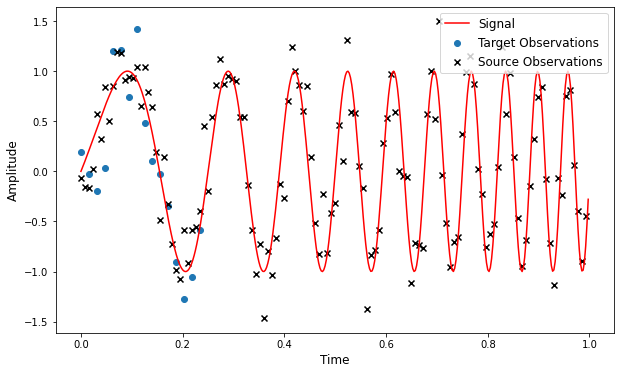

In [89]:
plt.figure(figsize = (10,6))
plt.scatter(x_target_train, y_target_train, label = 'Target Observations')
plt.scatter(x_source, y_source, label = 'Source Observations', marker = 'x', c = 'k')
plt.plot(index_points, y_index, label = 'Signal', c='r')

plt.legend(loc='upper right',fontsize = 'large')
plt.xlabel('Time',fontsize = 'large')
plt.ylabel('Amplitude',fontsize = 'large')

Construct the isolated source model
-------------

Matern 5/2 times the non-stationary periodic



------------

In [90]:
def build_source_gp_model(amplitude_se, length_scale_se, amplitude_pe, 
                          length_scale_pe, period, concentration0, concentration1):

    kernel_1 = tfk.MaternFiveHalves(amplitude = amplitude_se, length_scale = length_scale_se)
    kernel_2 = tfk.ExpSinSquared(amplitude = amplitude_pe, length_scale = length_scale_pe, period = period)
    
    kernel_3 = tfk.KumaraswamyTransformed(kernel_2, concentration0= concentration0, concentration1 = concentration1)
    model_kernel = kernel_1*kernel_3

    return tfd.GaussianProcess(
      kernel = model_kernel,
      index_points = x_source,
      observation_noise_variance = Pn_s)


sample_amp_se = np.zeros([10],dtype = np.float64);
sample_len_se = np.zeros([10],dtype = np.float64);
sample_amp_pe = np.zeros([10],dtype = np.float64);
sample_len_pe = np.zeros([10],dtype = np.float64);
sample_period = np.zeros([10],dtype = np.float64);
sample_concentration0 = np.zeros([10],dtype = np.float64);
sample_concentration1 = np.zeros([10],dtype = np.float64);
mc_norm_error_source_samples = np.zeros([10],dtype = np.float64);


#Optimize kernel hyperparameters for 10 different sets of initial hyperparameter values
#calculate the errors

for k in range(10):
 

    gp_joint_model = tfd.JointDistributionNamed({
        'amplitude_se': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'length_scale_se': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'amplitude_pe': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'length_scale_pe': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'period': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'concentration0': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'concentration1': tfd.LogNormal(loc=0., scale=np.float64(1.)),
        'observations': build_source_gp_model,
    })



    constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

    amplitude_se_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='amplitude_se',
        dtype=tf.float64)

    length_scale_se_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='length_scale_se',
        dtype=tf.float64)


    amplitude_pe_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='amplitude_pe',
        dtype=tf.float64)

    length_scale_pe_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='length_scale_pe',
        dtype=tf.float64)


    period_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='period',
        dtype=tf.float64)


    concentration0_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='concentration0',
        dtype=tf.float64)


    concentration1_var_source = tfp.util.TransformedVariable(
        initial_value=np.random.gamma(0.7,1.7),
        bijector=constrain_positive,
        name='concentration1',
        dtype=tf.float64)


    trainable_variables = [v.trainable_variables[0] for v in 
                           [amplitude_se_var_source,
                           length_scale_se_var_source, 
                           amplitude_pe_var_source,
                           length_scale_pe_var_source,
                            period_var_source,
                            concentration0_var_source,
                            concentration1_var_source
                           ]]



    @tf.function(autograph=False, experimental_compile=False)
    def target_log_prob(amplitude_se, length_scale_se, amplitude_pe, length_scale_pe, period, concentration0,
                        concentration1):
        return gp_joint_model.log_prob({
          'amplitude_se': amplitude_se,
          'length_scale_se': length_scale_se,
          'amplitude_pe': amplitude_pe,
          'length_scale_pe': length_scale_pe,
            'period' : period,
            'concentration0': concentration0,
            'concentration1': concentration1,
          'observations': y_source
        })


    for j in range(num_iters):
        with tf.GradientTape() as tape:
            loss = -target_log_prob(amplitude_se_var_source, length_scale_se_var_source, amplitude_pe_var_source,
                                    length_scale_pe_var_source, period_var_source, 
                                    concentration0_var_source, concentration1_var_source)
            
            grads = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))


    sample_amp_se[k] = amplitude_se_var_source.numpy();
    sample_len_se[k] = length_scale_se_var_source.numpy();
    
    sample_amp_pe[k] = amplitude_pe_var_source.numpy();
    sample_len_pe[k] = length_scale_pe_var_source.numpy();
    
    sample_period[k] = period_var_source.numpy();
    
    sample_concentration0[k] = concentration0_var_source.numpy();
    sample_concentration1[k] = concentration1_var_source.numpy();
    

    opt_kernel_1_source = tfk.MaternFiveHalves(amplitude = amplitude_se_var_source,
                                                     length_scale = length_scale_se_var_source)
    
    opt_kernel_2_source = tfk.ExpSinSquared(amplitude = amplitude_pe_var_source, length_scale = length_scale_pe_var_source,
                                           period = period_var_source)
    
    opt_kernel_3_source = tfk.KumaraswamyTransformed(opt_kernel_2_source, concentration0= concentration0_var_source,
                                                    concentration1 = concentration1_var_source)
    
    optimized_kernel_source = opt_kernel_1_source*opt_kernel_3_source

    

    gprm_source_SexPe_KM_Pe = tfd.GaussianProcessRegressionModel(
        kernel = optimized_kernel_source,
        index_points = x_source,
        observation_index_points = x_source,
        observations = y_source,
        observation_noise_variance = Pn_s,
        predictive_noise_variance=0.)


    samples_source = gprm_source_SexPe_KM_Pe.sample(num_samples)
    norm_error = np.zeros([num_samples])

    #sample from the posterior distribution
    for i in range(num_samples):
        norm_error[i] = np.sqrt(np.sum((samples_source[i] - chirp(x_source, chirp_rate, 2).reshape(len(x_source)))**2))

    mc_norm_error_source_samples[k] = np.mean(norm_error)

In [91]:
#construct the kernel function using the values which correspond to
#model which minimized error

optimum_khp = mc_norm_error_source_samples.argmin()
    
    
opt_kernel_1_source = tfk.MaternFiveHalves(amplitude = sample_amp_se[optimum_khp], 
                                                 length_scale = sample_len_se[optimum_khp])
opt_kernel_2_source = tfk.ExpSinSquared(amplitude = sample_amp_pe[optimum_khp], 
                                        length_scale = sample_len_pe[optimum_khp],
                                       period = sample_period[optimum_khp])

opt_kernel_3_source = tfk.KumaraswamyTransformed(opt_kernel_2_source, concentration0= sample_concentration0[optimum_khp],
                                                concentration1 = sample_concentration1[optimum_khp])

optimized_kernel_source = opt_kernel_1_source*opt_kernel_3_source


#construct the GPR model with the optimized kernel
gprm_source = tfd.GaussianProcessRegressionModel(
            kernel = optimized_kernel_source,
            index_points = x_source,
            observation_index_points = x_source,
            observations = y_source,
            observation_noise_variance = Pn_s,
            predictive_noise_variance=0.)


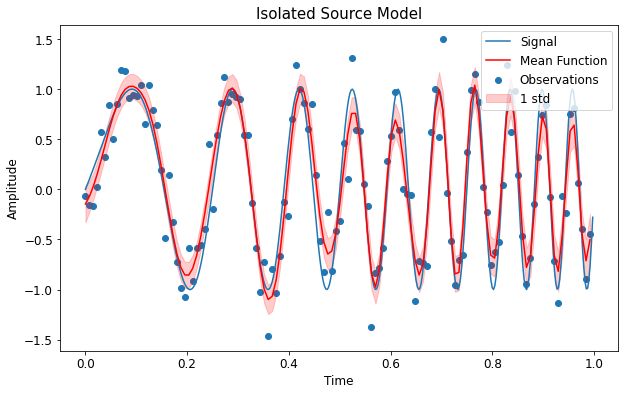

In [92]:
fig1 = plt.figure(figsize = (10,6));
plt.plot(index_points, y_index, label = 'Signal');
plt.plot(x_source, gprm_source.mean_fn(x_source), label = 'Mean Function', c='r');
plt.scatter(x_source, y_source, label='Observations');
plt.fill_between(x_source.reshape(-1),gprm_source.mean_fn(x_source).numpy().reshape(-1) + gprm_source.stddev(), 
                 gprm_source.mean_fn(x_source).numpy().reshape(-1) - gprm_source.stddev(), color = 'r', alpha = 0.2, label = '1 std');


leg = plt.legend(loc='upper right',fontsize = 'large');
plt.xlabel('Time',fontsize = 'large');
plt.ylabel('Amplitude',fontsize = 'large');
plt.title('Isolated Source Model',fontsize = 15);

plt.yticks(fontsize='large');
plt.xticks(fontsize='large');

Isolated Target
-----------

Single Matern 5/2 kernel

-------

In [93]:

#define the gp model with the kernel function
def build_target_gp_model(amplitude, length_scale):

    #Stationary Matern 5/2 kernel
    model_kernel = tfk.MaternFiveHalves(amplitude = amplitude, length_scale = length_scale)

    return tfd.GaussianProcess(
      kernel = model_kernel,
      index_points = x_target_train,
      observation_noise_variance = Pn_t)


#instantiate the joint distribution for the model variables
gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_target_gp_model
})


#instantiate the variables themselves and constrain them to be positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var_target = tfp.util.TransformedVariable(
    initial_value = 1.0,
    bijector=constrain_positive,
    name='amplitude',
    dtype=tf.float64)

length_scale_var_target = tfp.util.TransformedVariable(
    initial_value= 1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=tf.float64)

#These are the variables that will need to be trained
trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var_target,
                       length_scale_var_target]]


#log loss of joint distribution 
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observations': y_target_train
    })



lls_ = np.zeros(num_iters, np.float64)
#perform Adam optimization for the trainable variables
#loss is defined by calling the tareget_log_prob function - Log Loss
for j in range(num_iters):
    with tf.GradientTape() as tape:
        loss = -target_log_prob(amplitude_var_target, length_scale_var_target)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        lls_[j] = loss


#Create kernel mixture function using the optimized variables        
optimized_kernel_target = tfk.MaternFiveHalves(amplitude = amplitude_var_target, length_scale = length_scale_var_target)


#create the GPR model 
gprm_target = tfd.GaussianProcessRegressionModel(
    kernel = optimized_kernel_target,
    index_points = x_source,
    observation_index_points = x_target_train,
    observations = y_target_train,
    observation_noise_variance = Pn_t,
    predictive_noise_variance=0.)

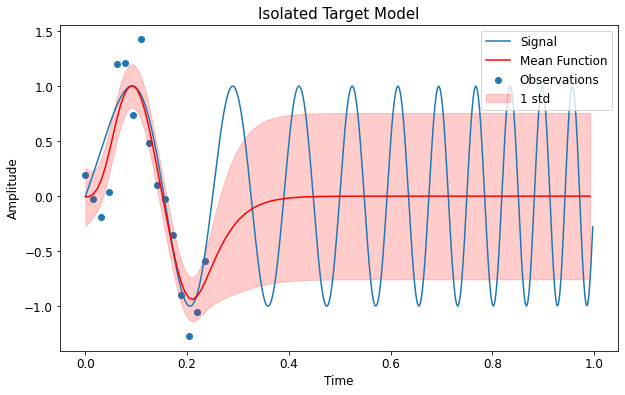

In [95]:
fig2 = plt.figure(figsize = (10,6))
plt.plot(index_points, y_index, label = 'Signal')
plt.plot(x_source, gprm_target.mean_fn(x_source), label = 'Mean Function', c='r')
plt.scatter(x_target_train, y_target_train, label='Observations')
plt.fill_between(x_source.reshape(-1),gprm_target.mean_fn(x_source).numpy().reshape(-1) + gprm_target.stddev(), 
                 gprm_target.mean_fn(x_source).numpy().reshape(-1) - gprm_target.stddev(), color = 'r', alpha = 0.2, label = '1 std');


leg = plt.legend(loc='upper right',fontsize = 'large')
plt.xlabel('Time',fontsize = 'large')
plt.ylabel('Amplitude',fontsize = 'large')
plt.title('Isolated Target Model',fontsize = 15)

plt.yticks(fontsize='large');
plt.xticks(fontsize='large');

Instantiating the mean functions and covariance kernels for source and target
-------

Convention adopted:

$K(x,x)$ = covariance_f

$K(x,x) + \sigma^2I$ = covariance_y

In [96]:
covariance_target_f = gprm_target.covariance();

#converting from tensorflow objects to numpy for easy manipulation
covariance_target_f = np.array(covariance_target_f);

#shape is 128,128 as the covariance kernel is defined for the whole signal
print(covariance_target_f.shape)

(128, 128)


In [97]:
mean_fn_source = gprm_source.mean_fn(x_source)

covariance_source_f = gprm_source.covariance()

covariance_source_y = covariance_source_f + (Pn_s*np.identity(len(x_source)))


#converting from tensorflow objects to numpy for easy manipulation
mean_fn_source = np.array(mean_fn_source);
covariance_source_f = np.array(covariance_source_f)
covariance_source_y = np.array(covariance_source_y)

print(covariance_source_y.shape)
print(mean_fn_source.shape)

(128, 128)
(128,)


In [98]:
#noise variance for source and target
print("Source noise variance: ", Pn_s)
print("Target noise variance: ", Pn_t)

Source noise variance:  0.08944271909999159
Target noise variance:  0.1449559327355391


Find the locations where the target model has made observations
-------------

In [99]:
obs_loc = np.where(x_source == x_target_train.reshape(-1))[0]

In [100]:
obs_loc

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
      dtype=int64)

In [101]:
x_source[obs_loc]

array([[0.      ],
       [0.015625],
       [0.03125 ],
       [0.046875],
       [0.0625  ],
       [0.078125],
       [0.09375 ],
       [0.109375],
       [0.125   ],
       [0.140625],
       [0.15625 ],
       [0.171875],
       [0.1875  ],
       [0.203125],
       [0.21875 ],
       [0.234375]])

Define the mean functions and covariance kernels for only those points where the target made observations
----------

These are the values that are needed for algorithm

In [102]:
covariance_target_f_obs = covariance_target_f[obs_loc[:,None],obs_loc]
covariance_source_y_obs = covariance_source_y[obs_loc[:,None],obs_loc]

mean_fn_source_obs = mean_fn_source[obs_loc]

print(covariance_target_f_obs.shape)
print(covariance_source_y_obs.shape)
print(mean_fn_source_obs.shape)

(16, 16)
(16, 16)
(16,)


ICM coefficients
----

In [103]:
a_s = 1
a_t = 1

In [104]:
b_matrix = np.matmul(np.array([a_s, a_t]).reshape(-1,1), np.transpose(np.array([a_s, a_t]).reshape(-1,1)))
b_matrix

array([[1, 1],
       [1, 1]])

In [105]:
b_matrix.shape

(2, 2)

Construct the K block matrix
------------

$K = \begin{bmatrix} K_{SS} & K_{ST} \\  K_{ST}^T & K_{TT} \end{bmatrix}$

In [106]:
K = np.kron(b_matrix, covariance_target_f_obs)
K.shape


(32, 32)

An example of np.Kron working correctly:
--------

In [107]:
example_mat = np.array([[2,5],[8,4]])
example_mat

array([[2, 5],
       [8, 4]])

In [108]:
np.kron(b_matrix, example_mat)

array([[2, 5, 2, 5],
       [8, 4, 8, 4],
       [2, 5, 2, 5],
       [8, 4, 8, 4]])

Optimum mean:
-----------

$m^{o}_T = k_T(K + blkdiag(R_s, \sigma^2_T I_n))^{-1} \begin{bmatrix} m_s \\ y_T \end{bmatrix}$ 

$k_T = [k_{TS}(x,x_S) k_{TT}(x,x_T)]$

First constructing $blkdiag(R_s, \sigma^2_T I_n)$

In [109]:
print("Number of training points for target: ", len(x_target_train))
print("Target noise variance: ", Pn_t)
print("Source covariance with the added noise: ", covariance_source_y_obs.shape)

Number of training points for target:  16
Target noise variance:  0.1449559327355391
Source covariance with the added noise:  (16, 16)


In [110]:
blkdiag = block_diag(covariance_source_y_obs, 
                     Pn_t*np.identity(len(x_target_train)))
blkdiag.shape

(32, 32)

Because there is a complete overlap of source, target, and inference points, K_T can be taken from the bottom half of the K block matrix

$k_T = [k_{TS}(x,x_S) k_{TT}(x,x_T)]$

In [111]:
K_T = K[16:,]
K_T.shape

(16, 32)

$\begin{bmatrix} m_s \\ y_T \end{bmatrix}$ 

In [112]:
print(mean_fn_source_obs)
print(mean_fn_source_obs.shape)

[-0.14629413  0.03172828  0.30079182  0.59794353  0.84930671  0.99780563
  1.02850292  0.9641749   0.78940182  0.4618024   0.01101507 -0.4476304
 -0.77848225 -0.85573256 -0.65803318 -0.24897178]
(16,)


In [113]:
print(y_target_train)
print(y_target_train.shape)

[ 0.19071503 -0.02307093 -0.19371489  0.03782267  1.19696436  1.21011287
  0.73854748  1.4228536   0.47895497  0.10523209 -0.0244281  -0.34869695
 -0.90056037 -1.26996482 -1.05070051 -0.58889833]
(16,)


In [114]:
vertical_block = np.append(mean_fn_source_obs, y_target_train, axis=0).reshape(-1,1)
vertical_block.shape

(32, 1)

In [115]:
print(vertical_block)

[[-0.14629413]
 [ 0.03172828]
 [ 0.30079182]
 [ 0.59794353]
 [ 0.84930671]
 [ 0.99780563]
 [ 1.02850292]
 [ 0.9641749 ]
 [ 0.78940182]
 [ 0.4618024 ]
 [ 0.01101507]
 [-0.4476304 ]
 [-0.77848225]
 [-0.85573256]
 [-0.65803318]
 [-0.24897178]
 [ 0.19071503]
 [-0.02307093]
 [-0.19371489]
 [ 0.03782267]
 [ 1.19696436]
 [ 1.21011287]
 [ 0.73854748]
 [ 1.4228536 ]
 [ 0.47895497]
 [ 0.10523209]
 [-0.0244281 ]
 [-0.34869695]
 [-0.90056037]
 [-1.26996482]
 [-1.05070051]
 [-0.58889833]]


$m^{o}_T = k_T(K + blkdiag(R_s, \sigma^2_T I_n))^{-1} \begin{bmatrix} m_s \\ y_T \end{bmatrix}$ 

In [116]:
print(K_T.shape)
print(K.shape)
print(blkdiag.shape)
print(vertical_block.shape)

(16, 32)
(32, 32)
(32, 32)
(32, 1)


In [117]:
mean_opt_target = np.matmul(
    np.matmul(K_T, np.linalg.inv((K + blkdiag))),
    vertical_block)

mean_opt_target.shape

(16, 1)

In [118]:
print(mean_opt_target)

[[-0.02774269]
 [ 0.01142648]
 [ 0.12350624]
 [ 0.31863009]
 [ 0.53634066]
 [ 0.6813777 ]
 [ 0.71652447]
 [ 0.64641408]
 [ 0.47287114]
 [ 0.23015396]
 [-0.04229111]
 [-0.31128876]
 [-0.52062045]
 [-0.60027463]
 [-0.52888481]
 [-0.3689009 ]]


Example of np.linalg.inv working:
-------------

In [119]:
example_mat

array([[2, 5],
       [8, 4]])

In [120]:
np.linalg.inv(example_mat)

array([[-0.125  ,  0.15625],
       [ 0.25   , -0.0625 ]])

$k^{o}_{qp}(x,x') = k_{qp}(x,x') - k_{q}(K + blkdiag(R, \sigma^2_{T}I_n))^{-1} k'_p$

Again because of complete overlap of points, K_T' can be taken from the right portion of the block matrix K

In [121]:
K_T_Prime = K[:,16:]
K_T_Prime.shape

(32, 16)

In [122]:
kernel_opt_target = covariance_target_f_obs - (np.matmul(
    np.matmul(K_T, np.linalg.inv(K + blkdiag)),
    K_T_Prime))

kernel_opt_target.shape

(16, 16)

In [123]:
#variances of each point is taken from the diagonal of the cov kernel

variances_opt_target = np.diagonal(kernel_opt_target)
variances_opt_target.shape

(16,)

In [124]:
variances_opt_target

array([0.02966703, 0.01703525, 0.01610171, 0.01598781, 0.01585291,
       0.01582323, 0.01582818, 0.01583564, 0.0158448 , 0.01585596,
       0.0158654 , 0.01590003, 0.01605375, 0.0161634 , 0.01675561,
       0.02851893])

Plotting the Optimum function without scaling:
-------------

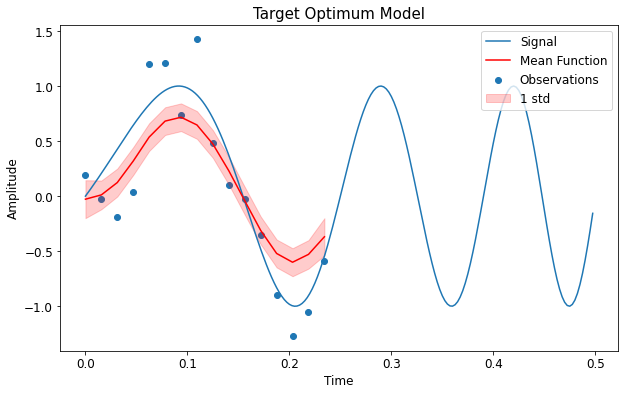

In [125]:
fig4 = plt.figure(figsize = (10,6))
plt.plot(index_points[:200], y_index[:200], label = 'Signal')
plt.plot(x_target_train, mean_opt_target, label = 'Mean Function', c='r')
plt.scatter(x_target_train, y_target_train, label='Observations')
plt.fill_between(x_target_train.reshape(-1),mean_opt_target.reshape(-1) + np.sqrt(abs(variances_opt_target)), 
                 mean_opt_target.reshape(-1) - np.sqrt(abs(variances_opt_target)), color = 'r', alpha = 0.2, label = '1 std')

leg = plt.legend(loc='upper right',fontsize = 'large')
plt.xlabel('Time',fontsize = 'large')
plt.ylabel('Amplitude',fontsize = 'large')
plt.title('Target Optimum Model',fontsize = 15)

plt.yticks(fontsize='large');
plt.xticks(fontsize='large');

In [126]:
#RMSE values
np.sqrt(np.sum((mean_opt_target.reshape(-1) - y_source_true[obs_loc])**2)/16)


0.26048321829792376

Now using scaling:
--------------

In [127]:
scaling_factor = (1 + (1.5*np.sqrt(Pn_s)))
scaling_factor

1.448604634366366

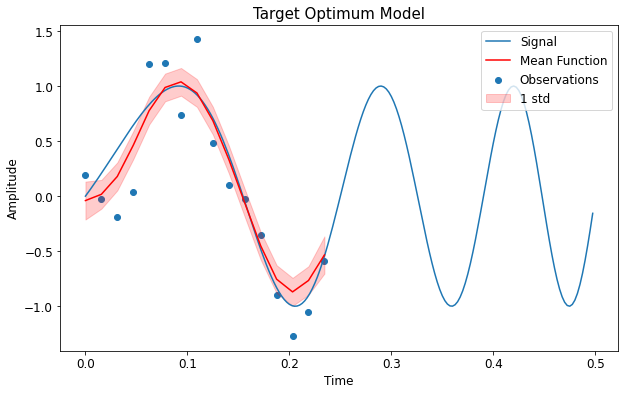

In [128]:
fig4 = plt.figure(figsize = (10,6))
plt.plot(index_points[:200], y_index[:200], label = 'Signal')
plt.plot(x_target_train, scaling_factor*mean_opt_target, label = 'Mean Function', c='r')
plt.scatter(x_target_train, y_target_train, label='Observations')
plt.fill_between(x_target_train.reshape(-1),scaling_factor*mean_opt_target.reshape(-1) + np.sqrt(variances_opt_target), 
                 scaling_factor*mean_opt_target.reshape(-1) - np.sqrt(variances_opt_target), color = 'r', alpha = 0.2, label = '1 std')

leg = plt.legend(loc='upper right',fontsize = 'large')
plt.xlabel('Time',fontsize = 'large')
plt.ylabel('Amplitude',fontsize = 'large')
plt.title('Target Optimum Model',fontsize = 15)

plt.yticks(fontsize='large');
plt.xticks(fontsize='large');


In [129]:
#RMSE
np.sqrt(np.sum((scaling_factor*mean_opt_target.reshape(-1) - y_source_true[obs_loc])**2)/16)

0.10685787756156469